# Jores et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Jores et al (2021) dataset.
***

In [13]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [20]:
# General imports
import os
import glob
import torch
import numpy as np
import xarray as xr

# EUGENe imports and settings
from eugene import models
from eugene import interpret
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/fix_full/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/fix_full/jores21"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/jores21"

# EUGENe packages
import seqdata as sd
import seqpro as sp
import seqexplainer as se

# For illustrator editing
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [3]:
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "jores21_leaf_test_predictions.zarr"))

# Load the best model

In [4]:
leaf_model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "leaf_trial_3", "checkpoints", "*"))[0]
model = models.load_config(config_path="hybrid.yaml")
leaf_model = models.SequenceModule.load_from_checkpoint(leaf_model_file, arch=model.arch)

[rank: 0] Global seed set to 3


In [5]:
# Choose which model you want to intepret
name = "leaf"
model = leaf_model
sdata = sdata_leaf

# Feature attribution

In [6]:
interpret.attribute_sdata(
    model,
    sdata,
    method="DeepLift",
    reference_type="zero",
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


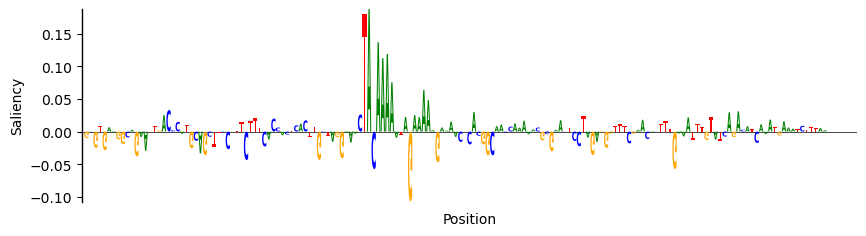

In [7]:
seq_id = "seq00000"
pl.seq_track(
    sdata,
    seq_id,
    attrs_key="DeepLift_attrs",
)

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

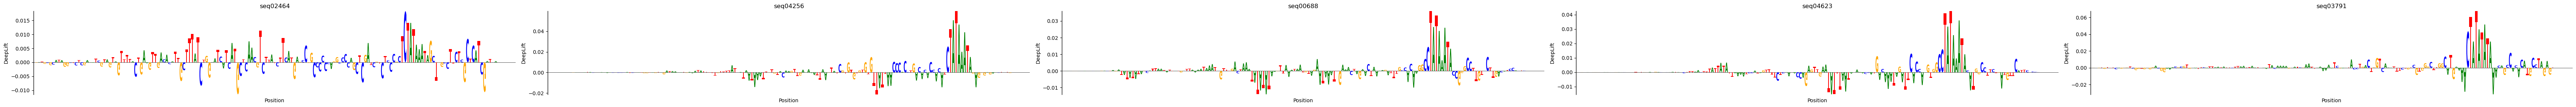

In [8]:
# Grab the top 5 in terms of predictions to plot tracks for
top5_inds = sdata["hybrid_leaf_trial_3_preds"].to_series().sort_values(ascending=False).iloc[:5].index
top5_ids = sdata["id"][top5_inds].values
top5_vals = sdata["hybrid_leaf_trial_3_preds"][top5_inds].values

pl.multiseq_track(
    sdata,
    seq_ids=top5_ids,
    attrs_keys = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=70,
    #save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_attr.pdf")
)

# Filter viz

In [24]:
layer_name = "arch.conv1d_tower.layers.1"

In [25]:
interpret.generate_pfms_sdata(
    model,
    sdata,
    seq_key="ohe_seq",
    layer_name=layer_name,
    kernel_size=13,
    transforms={"ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1)}
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

In [ ]:
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

In [18]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

NameError: name 'tot_ics' is not defined

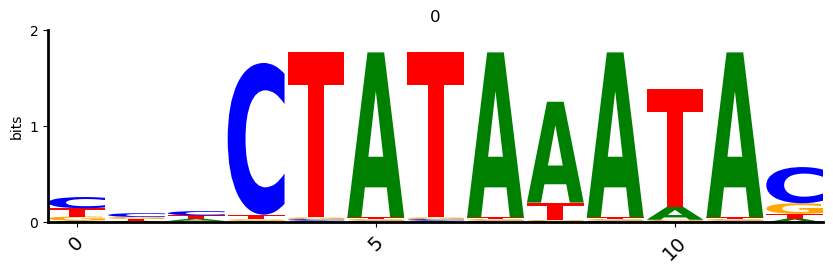

In [27]:
# Visualize a filter of choice
pl.filter_viz(
    sdata,
    filter_num=0,
    pfms_key=f"{layer_name}_pfms",
)

Plotting and saving filters 1-32
Plotting and saving filters 33-64
Plotting and saving filters 65-96
Plotting and saving filters 97-128
Plotting and saving filters 129-160
Plotting and saving filters 161-192
Plotting and saving filters 193-224
Plotting and saving filters 225-256


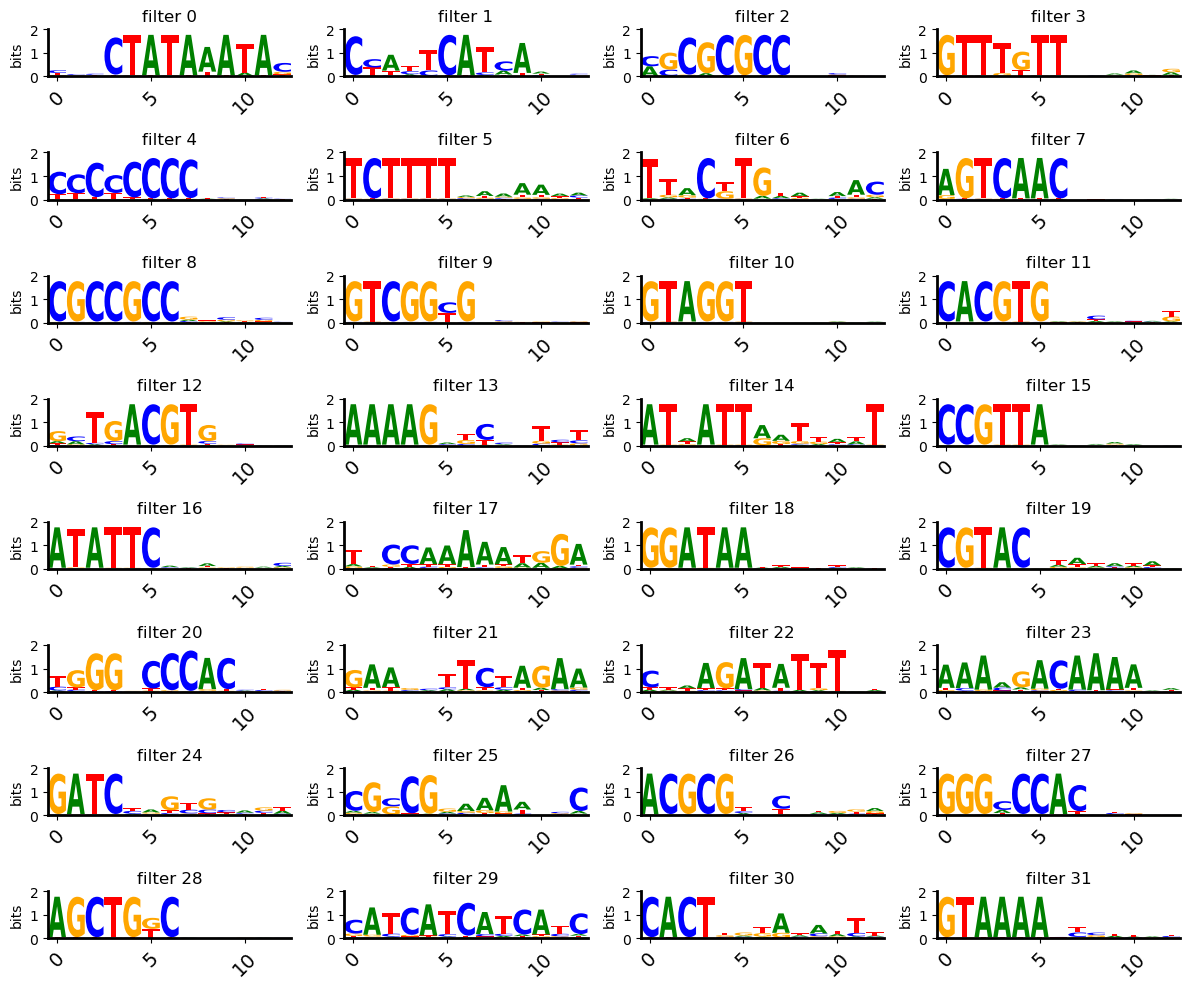

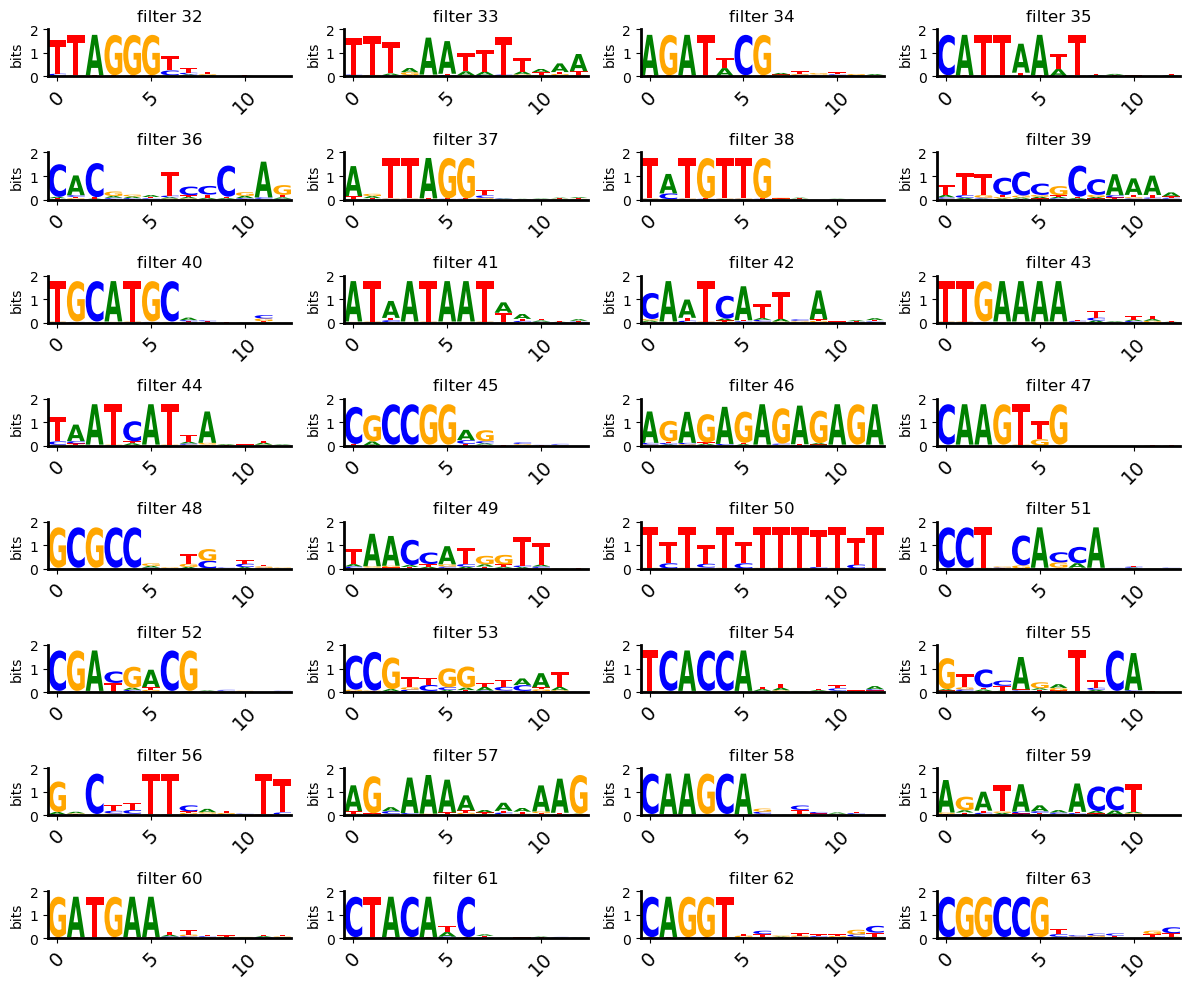

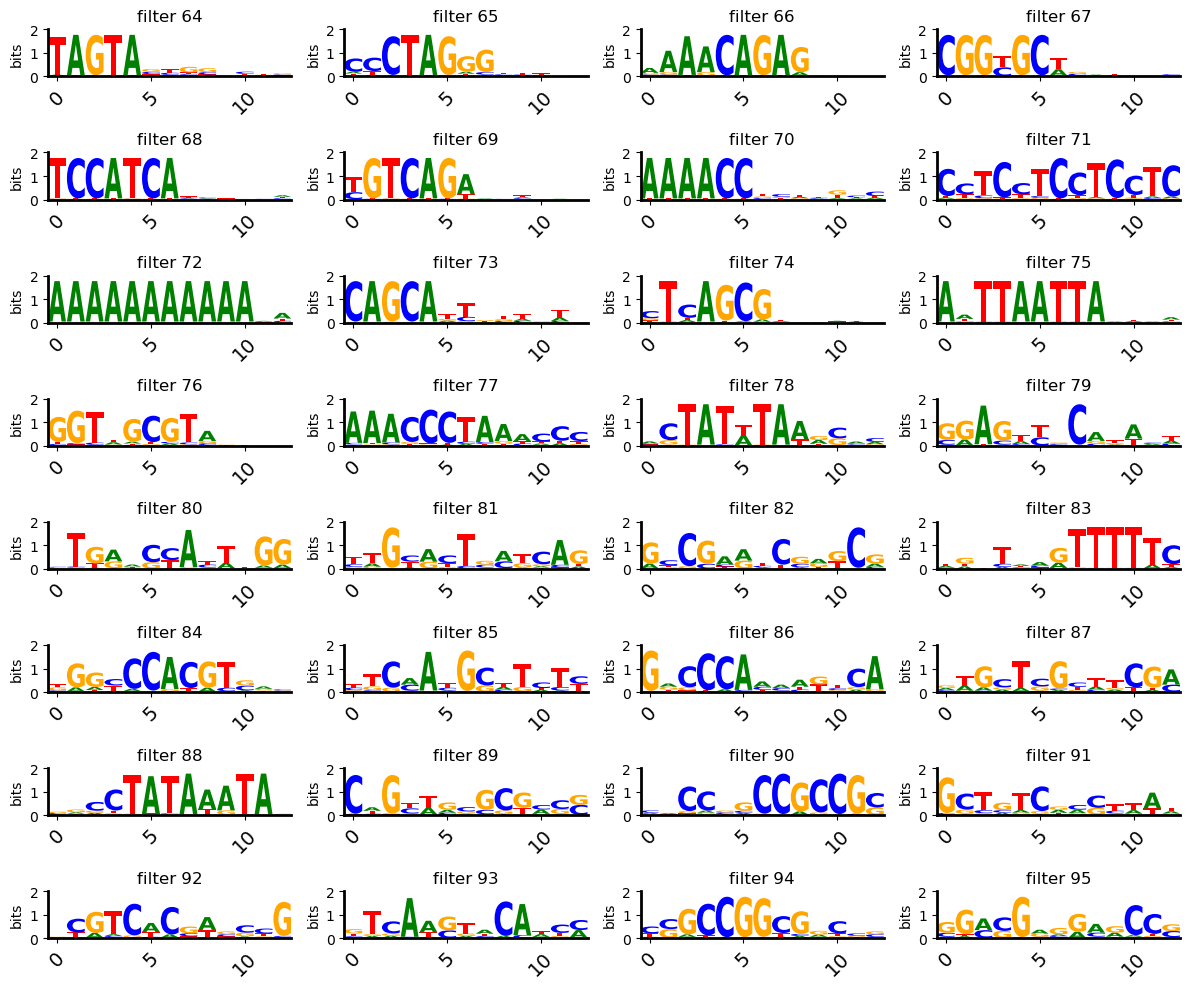

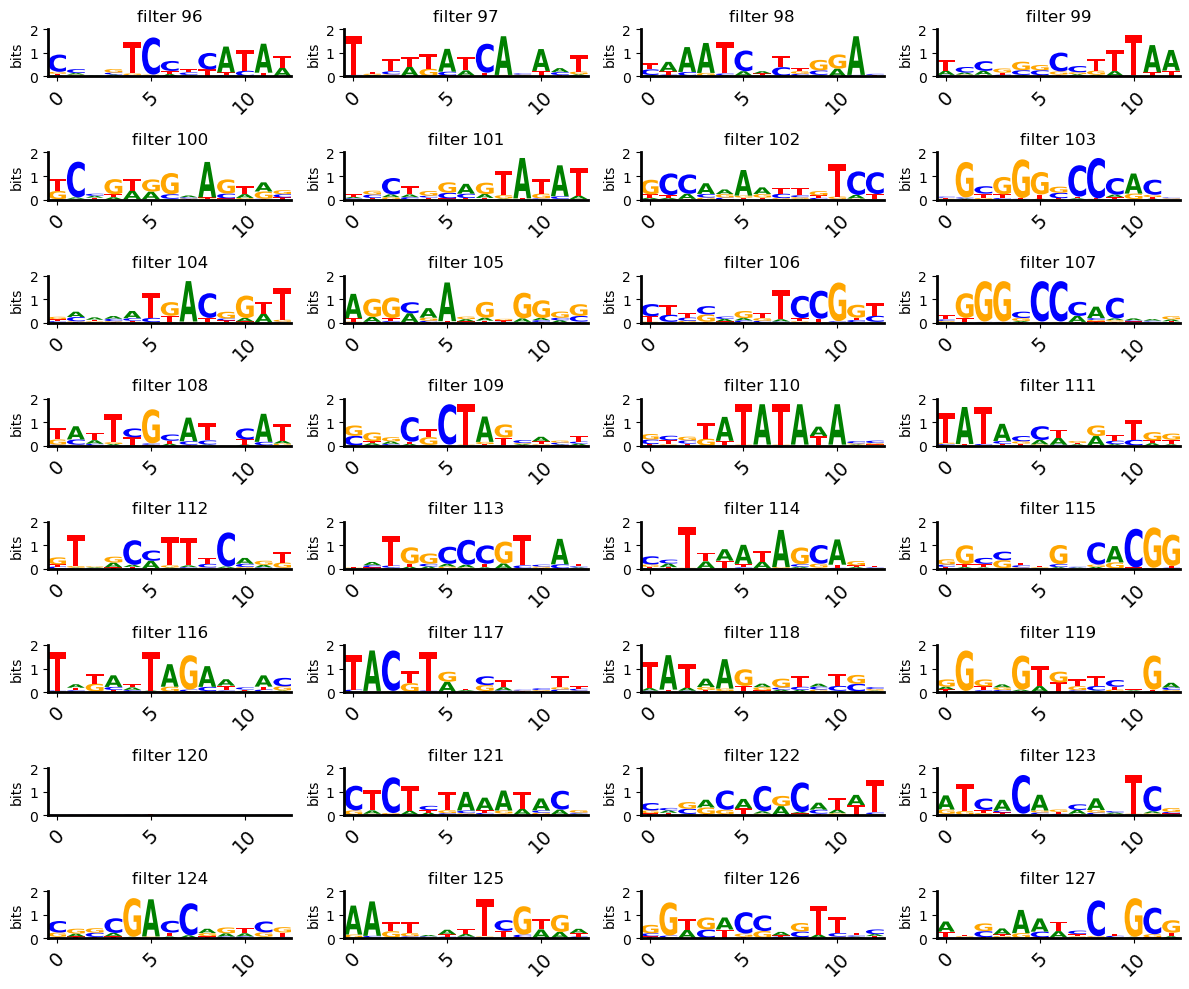

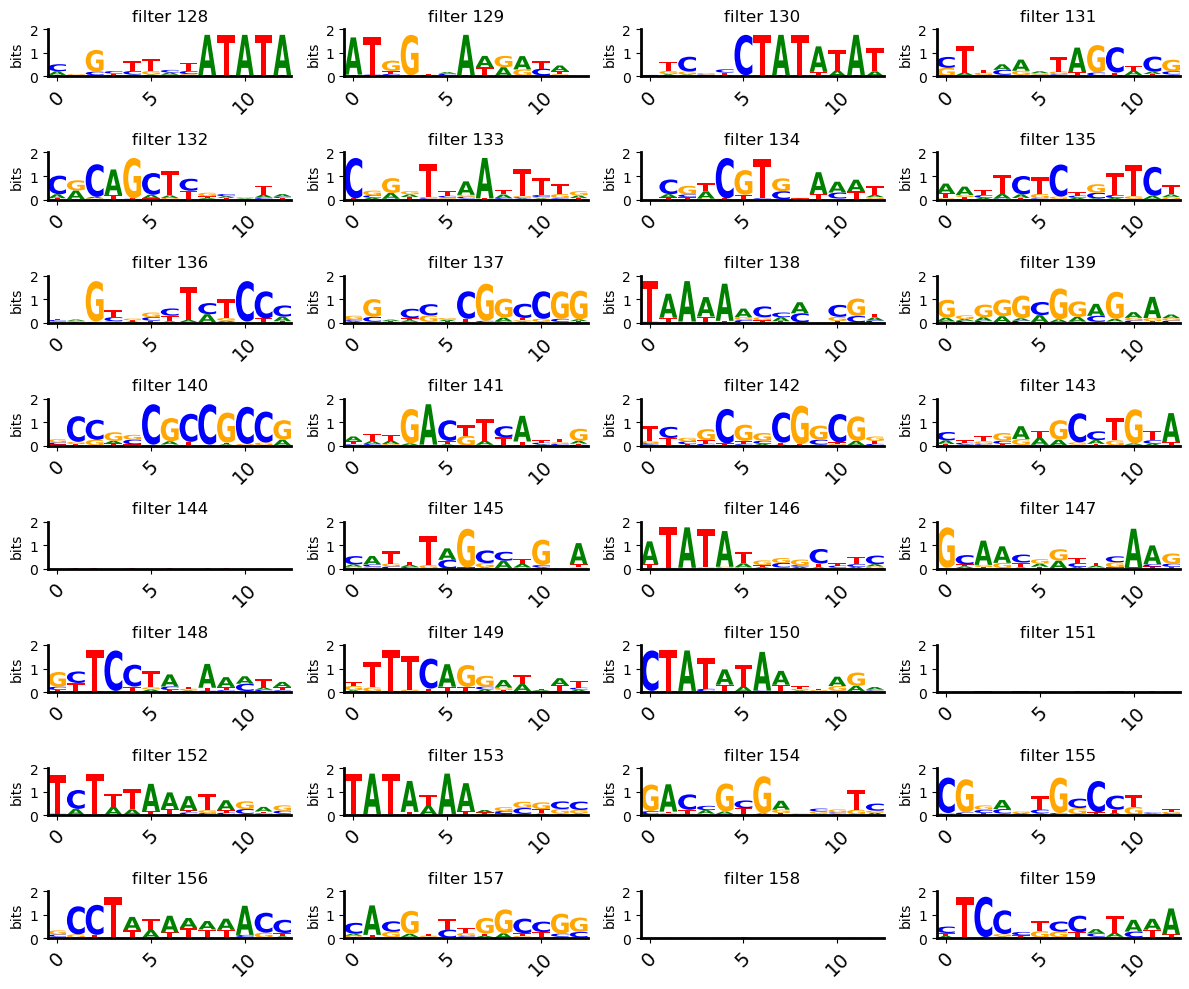

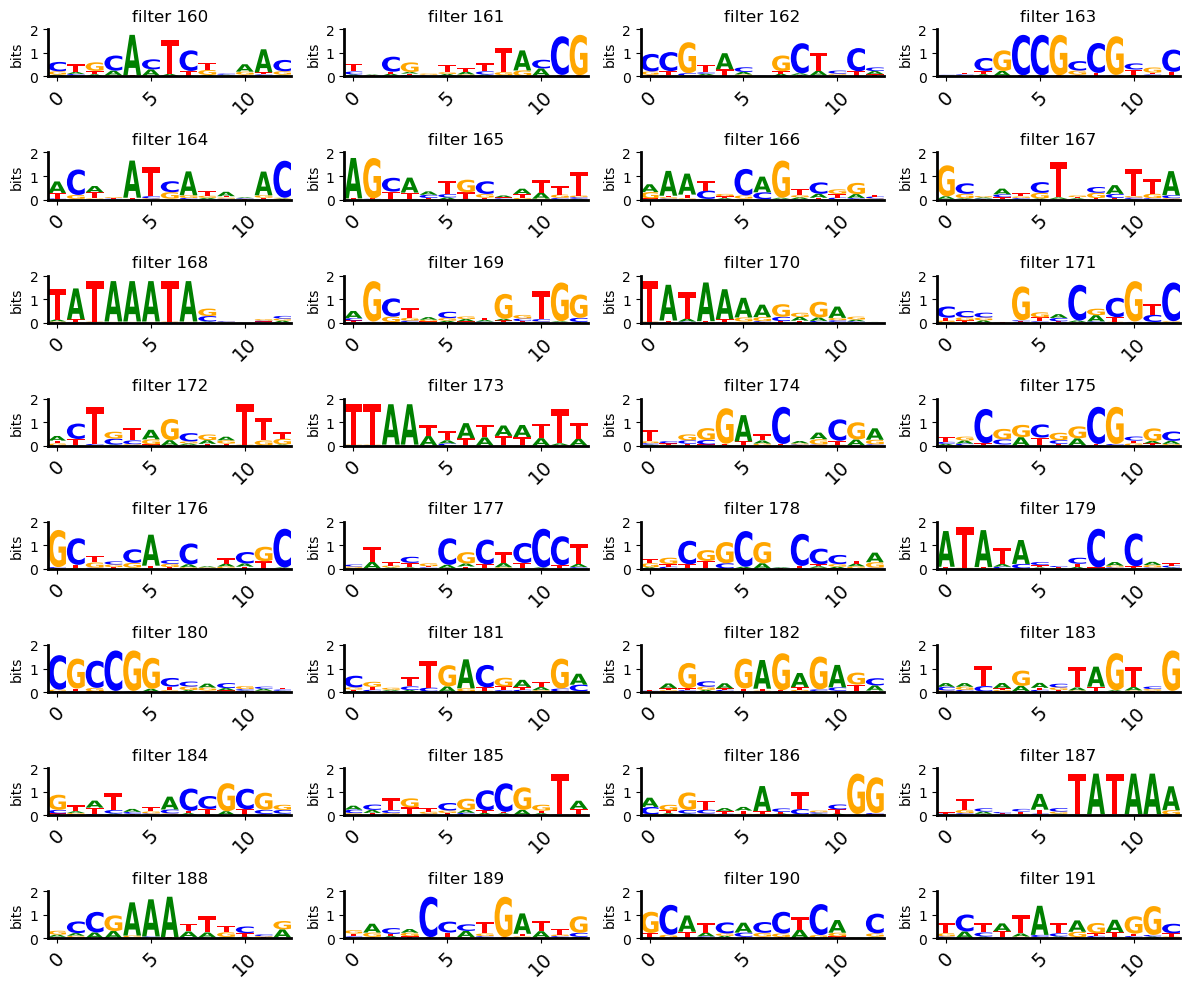

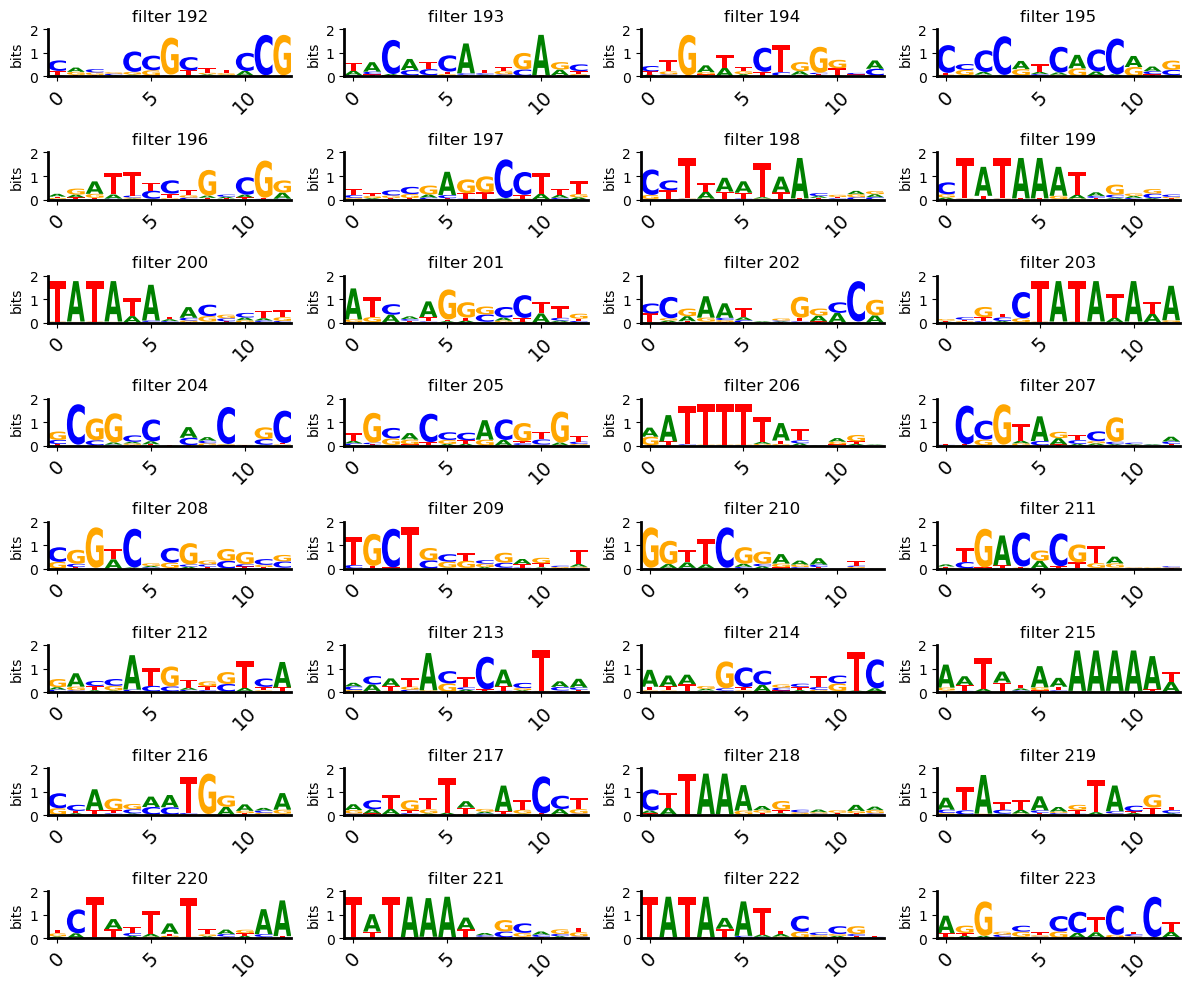

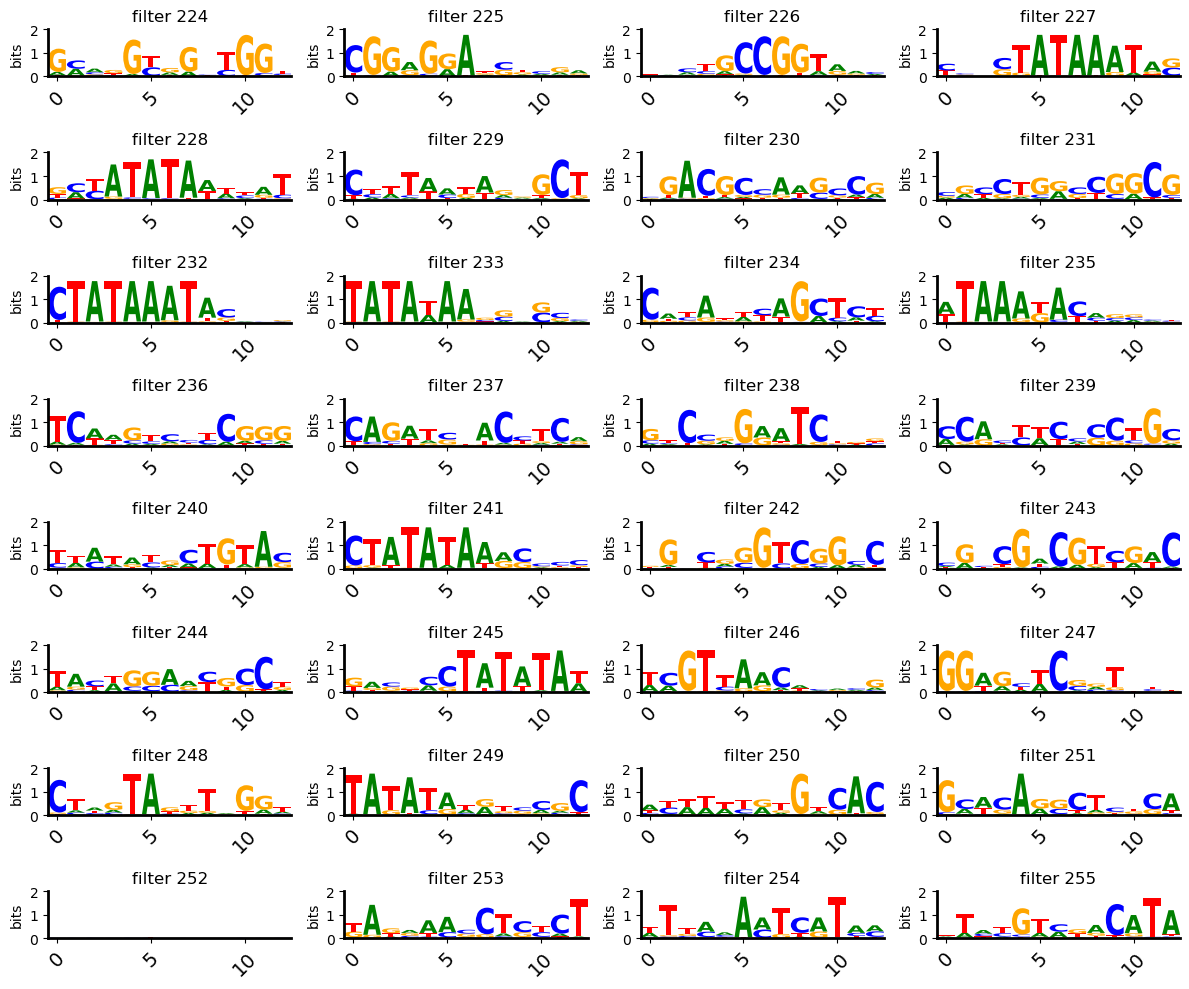

In [21]:
# Visualize multiple filters at once and save
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    pl.multifilter_viz(
        sdata,
        filter_nums=range(start_filter, end_filter),
        pfms_key=f"{prefix}{layer_name}_pfms{suffix}",
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(start_filter, end_filter)],
        #save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_filters{start_filter+1}-{end_filter}_viz.pdf")
    )

In [30]:
from motifdata import from_kernel

In [32]:
kernel = sdata[f"{layer_name}_pfms"].to_numpy()

In [34]:
kernel[0].T

array([[  6.,  45.,  16.,  33.],
       [ 17.,  42.,  21.,  20.],
       [ 19.,  39.,  12.,  30.],
       [  0.,  98.,   0.,   2.],
       [  0.,   0.,   0., 100.],
       [100.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.],
       [100.,   0.,   0.,   0.],
       [ 86.,   0.,   0.,  14.],
       [100.,   0.,   0.,   0.],
       [  9.,   0.,   0.,  91.],
       [100.,   0.,   0.,   0.],
       [  6.,  67.,  19.,   8.]], dtype=float32)

In [ ]:
from motifdata._transform import pfms_to_ppms

In [ ]:
pfms = sdata[f"{layer_name}_pfms"].transpose("_num_kernels", "_ohe", "_kernel_size").to_numpy(),
ppms = pfms_to_ppms()

In [50]:
motif_set = from_kernel(
    kernel=
    bg={"A": 0.25, "C": 0.25, "G": 0.25, "T": 0.25}
)

In [39]:
from motifdata import write_meme

In [51]:
write_meme(
    motif_set=motif_set,
    filename=os.path.join(settings.output_dir, f"{name}_best_model_filters.meme")
)

Saved pfm in MEME format as: /cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/fix_full/jores21/leaf_best_model_filters.meme


In [ ]:
sdata.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_test_predictions_and_interpretations.h5sd"))

## In silico evolution 

In [ ]:
# Load in sequences that were evolved in the published paper
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
eu.pp.ohe_seqs_sdata(sdata_evolve)
sdata_evolve

In [ ]:
# Evolve them using the best model across 10 rounds
eu.interpret.evolve_seqs_sdata(
    model,
    sdata_evolve,
    rounds=10
)

In [ ]:
# Plot the distribution of scores at different rounds of evolution
eu.pl.violinplot(
    sdata_evolve,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_evolution_summary.pdf")
)

In [ ]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences.h5sd")) 

# In silico feature implant

In [ ]:
sdata_evolve = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, name, f"{name}_evolved_sequences.h5sd"))

In [ ]:
# Prep feature from meme file
meme = eu.dl.motif.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
zero_pfm = np.zeros(pfm.shape)
rand_pfm = eu.pp.ohe_seq(eu.utils.random_seq(pfm.shape[0])).transpose()
consensus = motif.consensus
shuffled_pfm = eu.pp.ohe_seq(eu.pp.dinuc_shuffle_seq(consensus)).transpose()
feat_name, pfm, consensus

In [ ]:
# Slide the TATA motif across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seqsm_key=f"slide_{feat_name}",
    encoding="onehot", 
    onehot=True
)

# Slide a random seq across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=rand_pfm,
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)

# Slide a zero ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=zero_pfm,
    seqsm_key=f"slide_zero",
    encoding="onehot", 
    onehot=True
)

# Slide a TATA shuffled ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_evolve, 
    feature=shuffled_pfm,
    seqsm_key=f"slide_shuffled",
    encoding="onehot", 
    onehot=True
)

In [ ]:
# Check the average percentage increase across the sequences and positions
mean_original = sdata_evolve["original_score"].mean()
avg_increase = np.mean(np.subtract(sdata_evolve.seqsm["slide_TATA"], np.expand_dims(sdata_evolve["original_score"], axis=1)), axis=1)
(avg_increase.mean()/mean_original).mean()*100

In [ ]:
# Generate a line plot
eu.pl.feature_implant_plot(
    sdata_evolve,
    seqsm_keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    save=os.path.join(eu.settings.figure_dir, f"{name}_best_model_feature_implant_TATA.pdf")
)

In [ ]:
sdata_evolve.write_h5sd(os.path.join(eu.settings.output_dir, f"{name}_evolved_sequences_with_TATA_implant.h5sd")) 

---